In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpl
import matplotlib.gridspec as gridspec
from math import log, pow, exp, floor, ceil
from bisect import bisect, bisect_left, bisect_right
from collections import OrderedDict
import pandas as pd

In [2]:
%matplotlib inline
# plt.style.use('ggplot')
# mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.figsize'] = (12.0, 7.0)  # default size of plots
mpl.rcParams['font.size'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 16

# Correction function

In [3]:
def correction(et, p0, p1, p2, p3, p4, p5):
    part1 = p1 / (np.log10(et)**2 + p2)
    part2 = p3 * np.exp(-1. * p4 * (np.log10(et) - p5)**2)
    return p0 + part1 + part2

Let's look at the 1st order differential of our correction fn:

In [4]:
def differential_part1(et, p0, p1, p2, p3, p4, p5):
    return ((-2. * p1 * np.log10(et))/(log(10) * et * np.power((np.power(np.log10(et), 2) + p2), 2)))

In [5]:
def differential_part2(et, p0, p1, p2, p3, p4, p5):
    part2 = (-1. * p3 * p4 * (np.log10(et) - p5)) / (et * log(10))
    partexp = np.exp(-1. * p4 * np.power((np.log10(et) - p5), 2))
    return part2 * partexp

In [6]:
def differential(et, p0, p1, p2, p3, p4, p5):
    return differential_part1(et, p0, p1, p2, p3, p4, p5) + differential_part2(et, p0, p1, p2, p3, p4, p5)

Plot both the correction function and its differential as function of $E_T$

In [7]:
p0, p1, p2, p3, p4, p5 = 3.18556244,25.56760298,2.51677342,-103.26529010,0.00678420,-18.73657857

et = np.arange(0.5, 1024.5, 0.5)
corr = correction(et, p0, p1, p2, p3, p4, p5)
diff = differential(et, p0, p1, p2, p3, p4, p5)
diff_p1 = differential_part1(et, p0, p1, p2, p3, p4, p5)
diff_p2 = differential_part2(et, p0, p1, p2, p3, p4, p5)

In [8]:
print et[150], corr[150], corr[151], diff[150], diff[151]
print 2*(corr[150]-corr[151])

75.5 1.63680509916 1.63390812008 -0.0104747697739 -0.0103783378869
0.00579395815175


(0.0, 20)

/Users/robina/.virtualenvs/L1JEC/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


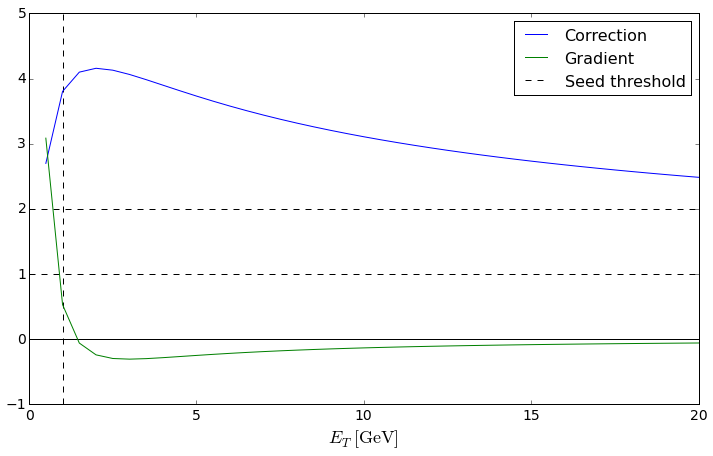

In [9]:
plt.plot(et, corr, label='Correction')
plt.plot(et, diff, label='Gradient')
# plt.plot(et, diff_p1, label='Gradient part 1')
# plt.plot(et, diff_p2, label='Gradient part 2')
plt.xlabel(r'$E_{T}\ \mathrm{[GeV]}$')
plt.vlines(1, plt.ylim()[0], plt.ylim()[1], linestyle='dashed', label='Seed threshold')
plt.legend(loc=0)
plt.hlines([1,2], plt.xlim()[0], plt.xlim()[1], linestyle='dashed')
plt.hlines(0, plt.xlim()[0], plt.xlim()[1])
# plt.ylim(-0.5,0.5)
plt.xlim(right=20)

There are some issues:

- EG have a correction factor between [1, 2]. We can't just assume that here since we are entirely dependent on the calibration of previous stages. Maybe the renage will be different? Maybe the lower bound should be < 1?

- What we'd really like to do is specify the range and offset. Then:

$f^{corr} = (\mathrm{LUT} \times \mathrm{range}) + \mathrm{offset}$

e.g. range 2, offset 0: values 0 -> 2
e.g. range 3, offset 3: values 3 -> 6

- How many bits would this need? (per curve)

    - range: 2 bits (0, 1, 2, 3)
    - offset: 2 bits (0, 1, 2, 3)

# Aim

Divide up pT range into 2^N bins, and optimise the binning such that the maximum difference (or RMS) for the correction factor is minimised.

Note that there are several 'layers' of quantisation/compromise:

- quantisation of pT -> several pT values must all use the same correction value

- quantisation of correction value -> can only have a certain number of bits to represent correction value, will inevitably be rounding errors.

## How EG do it

1) Convert shape, E, eta **[7, 8, 5 bits = 20 bits]** into compressed versions **[4, 4, 4 bits = 12 bits]**

2) Convert that to LUT index (i.e. compressedShape + compressedE<<4 + compressedIeta<<8)

3) Get correction factor **[9 bits]**

This therefore requires 2 LUTs: one to do mapping in (1), requiring 2^7+2^8+2^5 = 416 entries. And another in step 2/3 to get correction factor, requiring 2^12 entries, each of which can have an integer up to 511.

##  Grouping bins

We start by doing the same thing as EG/Tau. We merge pT bins based on the relative size of their corrections: if they
are within X %, merge them and iterate. We stop once we have reached the desired number of pT bins.

We start at the high pT end, since that is where we can gain the most. The low pT end often changes fastest and thus requires more bins. We will iteratively take a bin, look at the next lowest pt bin, then decide whether to merge or not, and iterate.

Variables/questions to play with:

- how many final pT bins do we need?

- what is the merging criteria? And should it apply to **all** original bins, or use the new merged one?

- limit maximum number of bins that can be merged together?

- is it better to merge over all pT, or lots at high pT and nothing at low pT? (somewhat related to previous point)

- how to calculate the new correction factor? Mean? Error-weighted mean? Mean of min() and max() for that bin?

### Final number of bins

EG has 4 bits for E, 4 bits for shape, 4 bits for eta. We need the same number of bits for eta, but we have no shape, so could potentially have 8 bits for ET.

### Merging criterium

Start with a simple one: the correction values have to be the same within 5%. And we will require this of all the **original** values, otherwise can have > 5% deviation in the end.

### Maximum number of merge bins

Let's not limit this for now.

### Merge over all pT?

Let's see how it goes by not constraining merging to happen everywhere. 

### Correction calculation

Use the raw unweighted mean for now.

## First attempt

Basic merger - merge bins if all are within X%. Stops once we have few enough pT bins.

In [10]:
# Starting point
max_pt = 1024
pt_orig = np.arange(0.5, max_pt, 0.5)
corr_orig = correction(pt_orig, p0, p1, p2, p3, p4, p5)

In [11]:
len(pt_orig)-1

2046

In [12]:
target_num_bins = 2**8

In [13]:
def calc_new_mapping(target_num_bins, merge_criterium, verbose=False):
    """Calculate new pt/correction mappings. Returns 2 dicts, 
    one for original:quantised pt mapping, and one for pt:corr mapping.
    
    target_num_bins: target number of pT bins
    merge_criterium: bins will be merged if min(bins) * merge_crit > max(bins)
    """
    
    # hold pt mapping
    new_pt_mapping = {p:p for p in pt_orig}
    new_pt_mapping = OrderedDict(sorted(new_pt_mapping.items(), key=lambda t: t))

    # hold correction mapping
    new_corr_mapping = {p:c for p,c in zip(pt_orig, corr_orig)}
    new_corr_mapping = OrderedDict(sorted(new_corr_mapping.items(), key=lambda t: t))

    end_ind = len(pt_orig)-1

    while len(set(new_corr_mapping.values())) > target_num_bins:
        # start with larget number of bins, look at compatibility, 
        # then reduce bin span if necessary        
        start_ind = 0

        while start_ind < end_ind and end_ind > 2:
                
            corrs = corr_orig[start_ind: end_ind+1]
            if corrs.max() < (merge_criterium * corrs.min()):

                # since the merge is greedy, but we want to use all out possible bins,
                # we have to modify the last group to not go over our target number
                if (end_ind < len(pt_orig) -1
                    and target_num_bins > (len(set(new_corr_mapping.values())) - len(corrs))):

                    start_ind += target_num_bins - (len(set(new_corr_mapping.values())) - len(corrs)) - 2
                    corrs = corr_orig[start_ind: end_ind+1]

                if verbose:    
                    print 'max:', corrs.max(), 'min:', corrs.min()
                    print 'bin edges:', start_ind, end_ind

                mean_corr = corrs.mean()
                
                for i in xrange(start_ind, end_ind+1):
                    new_corr_mapping[pt_orig[i]] = mean_corr
                    new_pt_mapping[pt_orig[i]] = pt_orig[start_ind]

                end_ind = start_ind - 1
                if verbose: print len(set(new_corr_mapping.values())), 'diff pt values'
                
                break
            else:
                start_ind += 1
                
    mask = [k != v for k, v in new_pt_mapping.iteritems()]
    print 'Quantised above (inclusive):', pt_orig[mask.index(True)]
    return new_pt_mapping, new_corr_mapping

In [14]:
merge_crit = 1.05
new_pt_mapping, new_corr_mapping = calc_new_mapping(2**8, merge_crit)

Quantised above (inclusive): 126.5


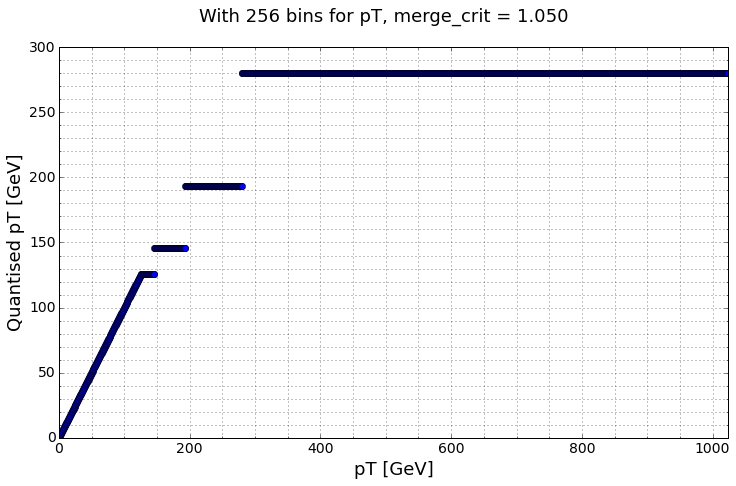

In [15]:
plt.plot(new_pt_mapping.keys(), new_pt_mapping.values(), 'o')
plt.xlabel('pT [GeV]')
plt.ylabel('Quantised pT [GeV]')
plt.xlim(right=1024)
plt.minorticks_on()
plt.grid(b=True, which='both')
plt.suptitle('With %d bins for pT, merge_crit = %.3f' % (target_num_bins, merge_crit))

In [16]:
def plot_corr_ratio(new_corr_mapping, target_num_bins=999, merge_criterium=999., pt_lim=500):
    """Make a plot with new correcitons values overlaid on old, with a ratio subplot."""
    
    fig = plt.figure()
    fig.set_size_inches(12,8)
    gs = gridspec.GridSpec(2, 1, height_ratios=[2.2, 1])
    gs.update(hspace=0.1)
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(pt_orig, corr_orig, 'o', label='Original correction')
    ax1.plot(new_corr_mapping.keys(), new_corr_mapping.values(), '^r', label='Quantised correction')
    ax1.set_ylabel('Correction value')
    ax1.legend(loc=0)
    ax1.minorticks_on()
    ax1.grid(b=True, which='major')
    title = 'With %d bins for pT with merge criterium %.3f' % (target_num_bins, merge_criterium)
    plt.suptitle(title)

    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax2.plot(new_corr_mapping.keys(), np.array(new_corr_mapping.values()) / corr_orig, 'xr', label='Ratio')
    ax2.minorticks_on()
    ax2.grid(b=True, which='major')
    ax2.set_ylabel('Quantised / Original')
    ax2.set_xlabel(r'$p_{T}^{L1}\ \mathrm{[GeV]}$')
    plt.setp(ax1.get_xticklabels(), visible=False)
    ax1.set_xlim(right=pt_lim)


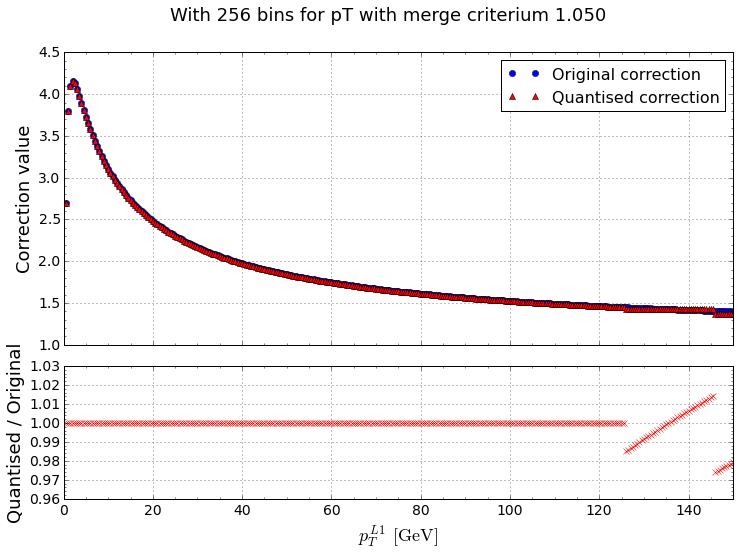

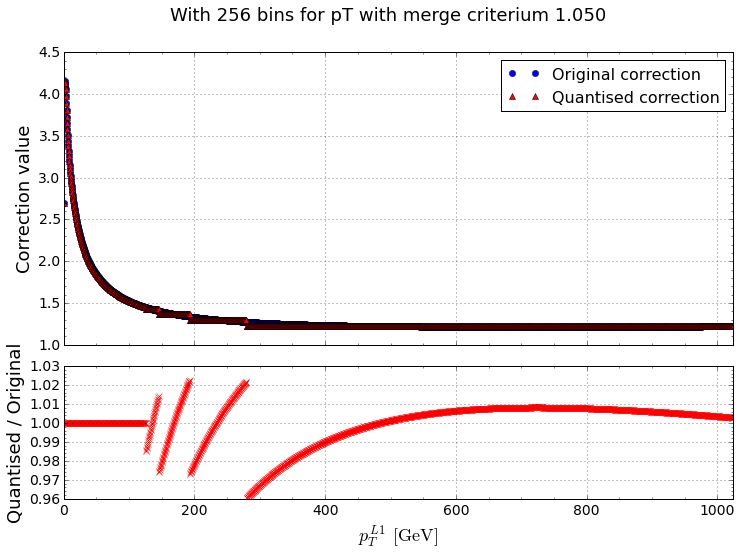

In [17]:
plot_corr_ratio(new_corr_mapping, target_num_bins=target_num_bins, merge_criterium=merge_crit, pt_lim=150)
plot_corr_ratio(new_corr_mapping, target_num_bins=target_num_bins, merge_criterium=merge_crit, pt_lim=1024)

Quantised above (inclusive): 119.0


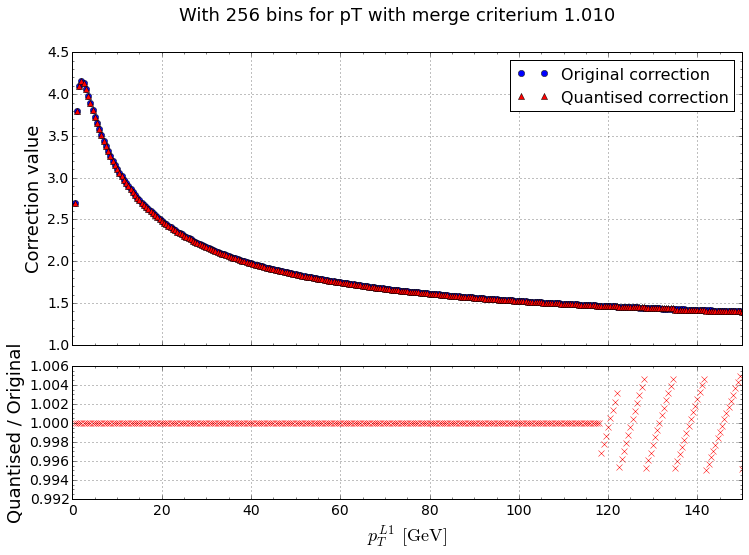

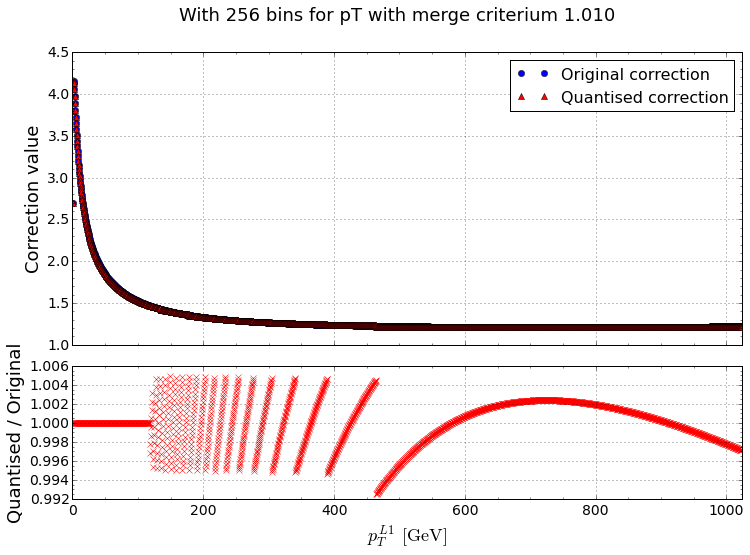

In [18]:
target = 2**8
merge = 1.01
new_pt_mapping, new_corr_mapping = calc_new_mapping(target, merge)
plot_corr_ratio(new_corr_mapping, target_num_bins=target, merge_criterium=merge, pt_lim=150)
plot_corr_ratio(new_corr_mapping, target_num_bins=target, merge_criterium=merge, pt_lim=1024)

Quantised above (inclusive): 60.5


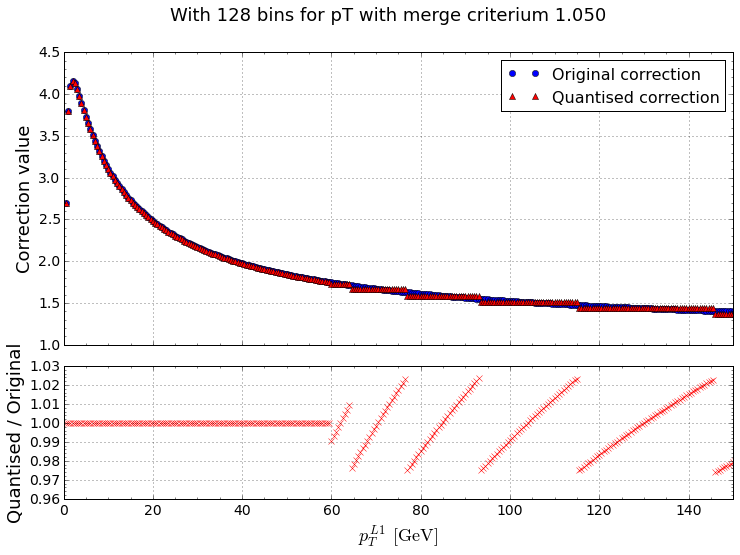

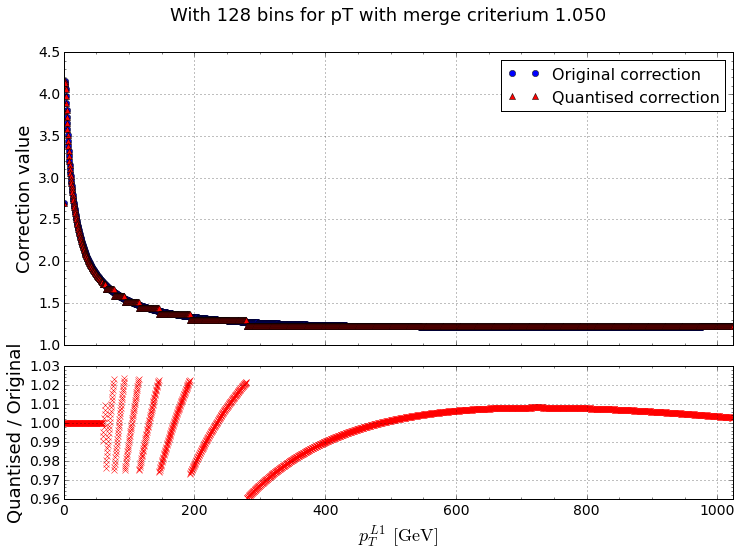

In [19]:
target = 2**7
merge = 1.05
new_pt_mapping, new_corr_mapping = calc_new_mapping(target, merge)
plot_corr_ratio(new_corr_mapping, target_num_bins=target, merge_criterium=merge, pt_lim=150)
plot_corr_ratio(new_corr_mapping, target_num_bins=target, merge_criterium=merge, pt_lim=1024)

Quantised above (inclusive): 127.5


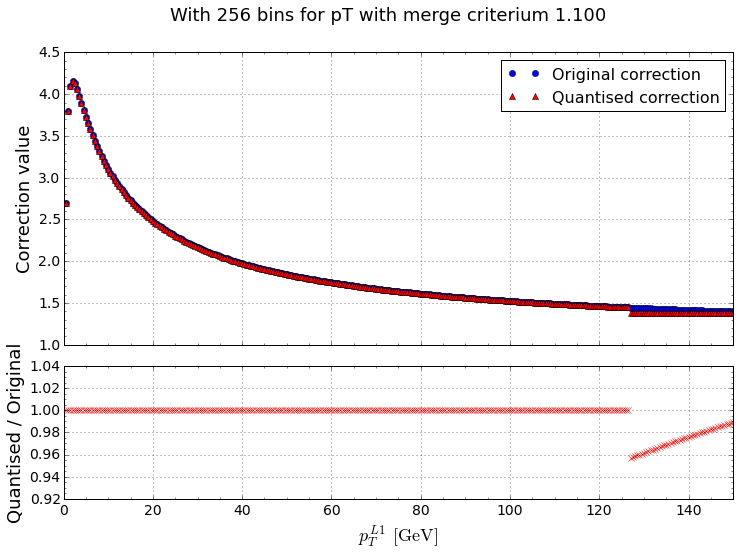

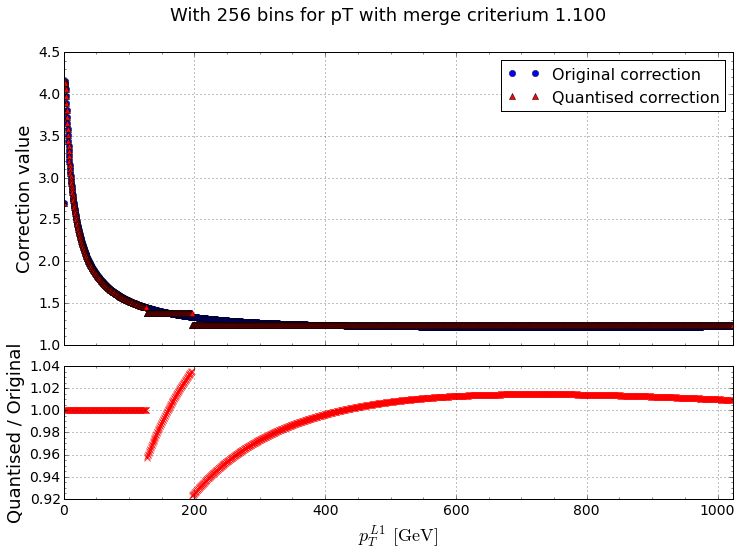

In [20]:
target = 2**8
merge = 1.1
new_pt_mapping, new_corr_mapping = calc_new_mapping(target, merge)
plot_corr_ratio(new_corr_mapping, target_num_bins=target, merge_criterium=merge, pt_lim=150)
plot_corr_ratio(new_corr_mapping, target_num_bins=target, merge_criterium=merge, pt_lim=1024)

Quantised above (inclusive): 123.0


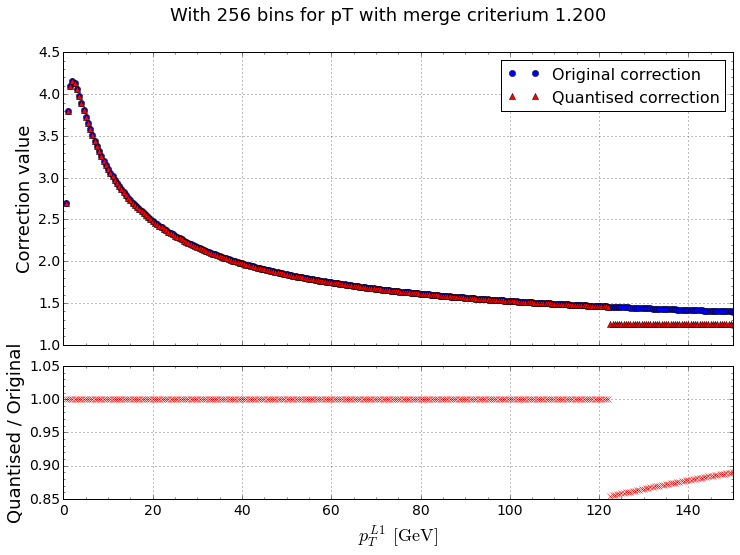

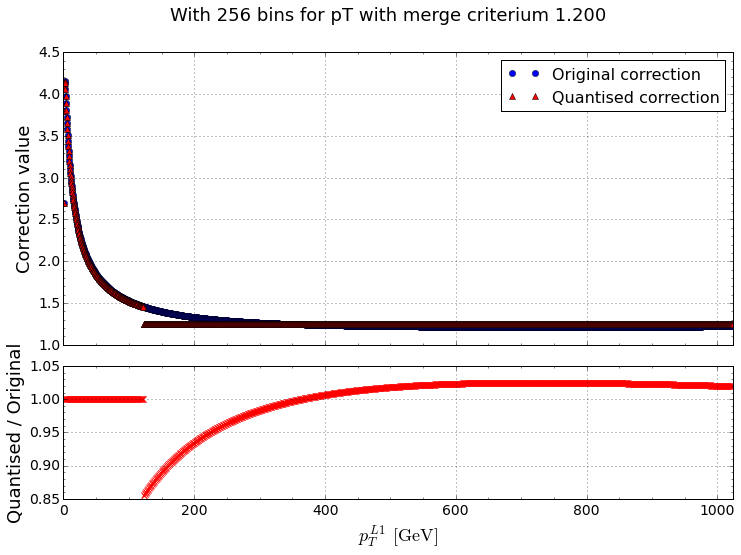

In [21]:
target = 2**8
merge = 1.2
new_pt_mapping, new_corr_mapping = calc_new_mapping(target, merge)
plot_corr_ratio(new_corr_mapping, target_num_bins=target, merge_criterium=merge, pt_lim=150)
plot_corr_ratio(new_corr_mapping, target_num_bins=target, merge_criterium=merge, pt_lim=1024)

## Aside: multiplier + bitshift

In the EG code, they do the correction by doing:
```cpp
int corr = params_->egCalibrationLUT()->data(lutAddress); // 9 bits. [0,1]. corrPt = (1+corr)*rawPt
int rawPt = hwPt;
if(rawPt>255)
  rawPt = 255;// 8 bits threshold
int corrXrawPt = corr*rawPt;// 17 bits
// round corr*rawPt
int addPt = corrXrawPt>>9;// 8 MS bits (truncation)
int corrPt = rawPt + addPt;
//Saturation done in Demux
//if(corrPt>255) corrPt = 255;// 8 bits threshold
return corrPt;
```
So let's look at how the bitshifting works

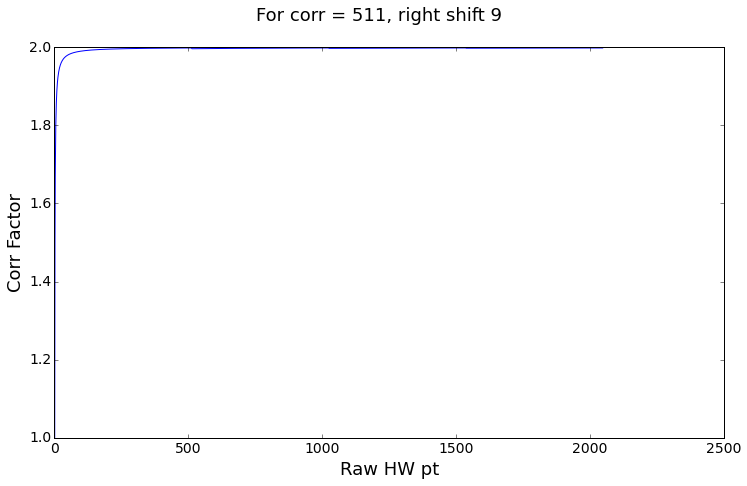

In [22]:
pt_raw = np.arange(1,2**11)  # HW pT
multiplier = 2**9 - 1

def corrected_pt(pt, corr_factor, rs):
    pt_new = corr_factor * np.array(pt)
    pt_new = np.right_shift(pt_new, rs)
    pt_new += pt_raw
    return pt_new

factor_9 = 1. * corrected_pt(pt_raw, multiplier, 9) / pt_raw
plt.plot(pt_raw, factor_9)
plt.xlabel('Raw HW pt')
plt.ylabel('Corr Factor')
plt.suptitle('For corr = 511, right shift 9')

So bitshift by 9 limits the overall correction factor between 1 and 2. Note that at low pT things don't quite work so well, so hop you don't need a larger factor there...!

In [23]:
x = multiplier * pt_raw
print 'RAW', 'CORRECTED', 'FACTOR'
for a,b in zip(pt_raw, corrected_pt(pt_raw, multiplier, 9)):
    if a > 50:
        break
    print a, b, 1. * b / a

RAW CORRECTED FACTOR
1 1 1.0
2 3 1.5
3 5 1.66666666667
4 7 1.75
5 9 1.8
6 11 1.83333333333
7 13 1.85714285714
8 15 1.875
9 17 1.88888888889
10 19 1.9
11 21 1.90909090909
12 23 1.91666666667
13 25 1.92307692308
14 27 1.92857142857
15 29 1.93333333333
16 31 1.9375
17 33 1.94117647059
18 35 1.94444444444
19 37 1.94736842105
20 39 1.95
21 41 1.95238095238
22 43 1.95454545455
23 45 1.95652173913
24 47 1.95833333333
25 49 1.96
26 51 1.96153846154
27 53 1.96296296296
28 55 1.96428571429
29 57 1.96551724138
30 59 1.96666666667
31 61 1.96774193548
32 63 1.96875
33 65 1.9696969697
34 67 1.97058823529
35 69 1.97142857143
36 71 1.97222222222
37 73 1.97297297297
38 75 1.97368421053
39 77 1.97435897436
40 79 1.975
41 81 1.9756097561
42 83 1.97619047619
43 85 1.97674418605
44 87 1.97727272727
45 89 1.97777777778
46 91 1.97826086957
47 93 1.97872340426
48 95 1.97916666667
49 97 1.97959183673
50 99 1.98


So e.g. if RAW pt = 50 (25 GeV) then the difference between a factor of 2 and 1.98 is 50 * 0.5 * (2-1.98) = 0.5 GeV, a 2% discrepancy

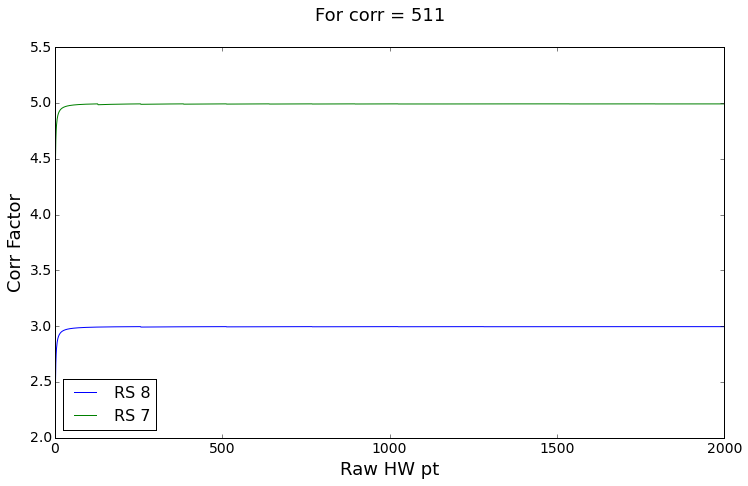

In [24]:
# pt_raw = np.arange(1,2**11)
multiplier = 2**9 - 1

factor_8 = 1. * corrected_pt(pt_raw, multiplier, 8) / pt_raw
plt.plot(pt_raw, factor_8, label='RS 8')


factor_7 = 1. * corrected_pt(pt_raw, multiplier, 7) / pt_raw
plt.plot(pt_raw, factor_7, label='RS 7')

plt.legend(loc=0)
plt.ylim(top=5.5)
plt.xlim(right=2000)
plt.xlabel('Raw HW pt')
plt.ylabel('Corr Factor')
plt.suptitle('For corr = 511')

In [25]:
print 'RAW', 'CORRECTED', 'FACTOR'
for a,b in zip(pt_raw, corrected_pt(pt_raw, 511, 7)):
    if a > 50:
        break
    print a, b, 1. * b / a

RAW CORRECTED FACTOR
1 4 4.0
2 9 4.5
3 14 4.66666666667
4 19 4.75
5 24 4.8
6 29 4.83333333333
7 34 4.85714285714
8 39 4.875
9 44 4.88888888889
10 49 4.9
11 54 4.90909090909
12 59 4.91666666667
13 64 4.92307692308
14 69 4.92857142857
15 74 4.93333333333
16 79 4.9375
17 84 4.94117647059
18 89 4.94444444444
19 94 4.94736842105
20 99 4.95
21 104 4.95238095238
22 109 4.95454545455
23 114 4.95652173913
24 119 4.95833333333
25 124 4.96
26 129 4.96153846154
27 134 4.96296296296
28 139 4.96428571429
29 144 4.96551724138
30 149 4.96666666667
31 154 4.96774193548
32 159 4.96875
33 164 4.9696969697
34 169 4.97058823529
35 174 4.97142857143
36 179 4.97222222222
37 184 4.97297297297
38 189 4.97368421053
39 194 4.97435897436
40 199 4.975
41 204 4.9756097561
42 209 4.97619047619
43 214 4.97674418605
44 219 4.97727272727
45 224 4.97777777778
46 229 4.97826086957
47 234 4.97872340426
48 239 4.97916666667
49 244 4.97959183673
50 249 4.98


We'll use RS 7 for now as it has the largest range (and actually encompasses the whole function).

In [26]:
num_corr_ints = 512
pt_raw_m = np.ndarray(shape=(num_corr_ints, len(pt_raw)), dtype=int)
pt_corr_m = np.ndarray(shape=(num_corr_ints, len(pt_raw)), dtype=int)

for i in range(num_corr_ints):
    pt_raw_m[i] = np.arange(1, len(pt_raw)+1)

np.copyto(pt_corr_m, pt_raw_m)

In [27]:
pt_corr_m

array([[   1,    2,    3, ..., 2045, 2046, 2047],
       [   1,    2,    3, ..., 2045, 2046, 2047],
       [   1,    2,    3, ..., 2045, 2046, 2047],
       ..., 
       [   1,    2,    3, ..., 2045, 2046, 2047],
       [   1,    2,    3, ..., 2045, 2046, 2047],
       [   1,    2,    3, ..., 2045, 2046, 2047]])

In [28]:
for i in range(len(pt_raw_m)):
    pt_corr_m[i] = corrected_pt(pt_raw_m[i], i, 7)

In [29]:
pt_corr_m

array([[    1,     2,     3, ...,  2045,  2046,  2047],
       [    1,     2,     3, ...,  2060,  2061,  2062],
       [    1,     2,     3, ...,  2076,  2077,  2078],
       ..., 
       [    4,     9,    14, ..., 10177, 10182, 10187],
       [    4,     9,    14, ..., 10193, 10198, 10203],
       [    4,     9,    14, ..., 10209, 10214, 10219]])

In [30]:
# for correction factor 15
pt_corr_m[15]

array([   1,    2,    3, ..., 2284, 2285, 2286])

In [31]:
# look at all corrected values for pt 251 (no 0)
print pt_corr_m[:, 250]

[ 251  252  254  256  258  260  262  264  266  268  270  272  274  276  278
  280  282  284  286  288  290  292  294  296  298  300  301  303  305  307
  309  311  313  315  317  319  321  323  325  327  329  331  333  335  337
  339  341  343  345  347  349  351  352  354  356  358  360  362  364  366
  368  370  372  374  376  378  380  382  384  386  388  390  392  394  396
  398  400  401  403  405  407  409  411  413  415  417  419  421  423  425
  427  429  431  433  435  437  439  441  443  445  447  449  451  452  454
  456  458  460  462  464  466  468  470  472  474  476  478  480  482  484
  486  488  490  492  494  496  498  500  502  503  505  507  509  511  513
  515  517  519  521  523  525  527  529  531  533  535  537  539  541  543
  545  547  549  551  552  554  556  558  560  562  564  566  568  570  572
  574  576  578  580  582  584  586  588  590  592  594  596  598  600  602
  603  605  607  609  611  613  615  617  619  621  623  625  627  629  631
  633  635  

Note that although we achieve a larger range with a smaller bitshift, we have to deal with the fact that not every corrected value is now possible, e.g. no way to map 251 -> 255, only 254 or 256.

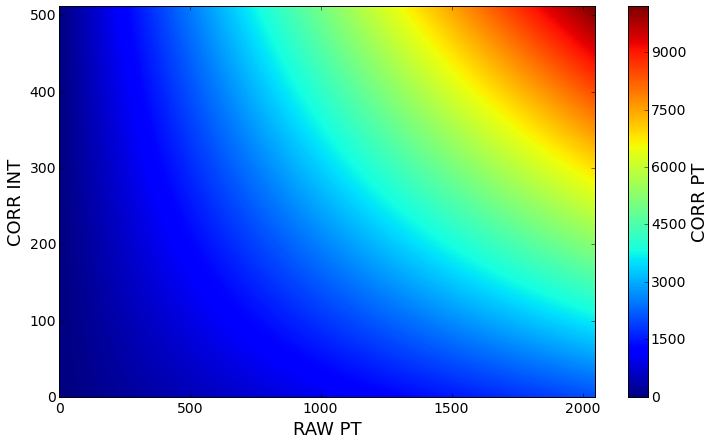

In [32]:
x, y = np.meshgrid(np.arange(0, len(pt_raw)), np.arange(0, len(pt_corr_m[:,0])))
plt.pcolormesh(x, y, pt_corr_m)
plt.colorbar(label='CORR PT')
plt.xlim(0, len(pt_raw))
plt.ylim(0, len(pt_corr_m[:,0]))
plt.xlabel("RAW PT")
plt.ylabel("CORR INT")

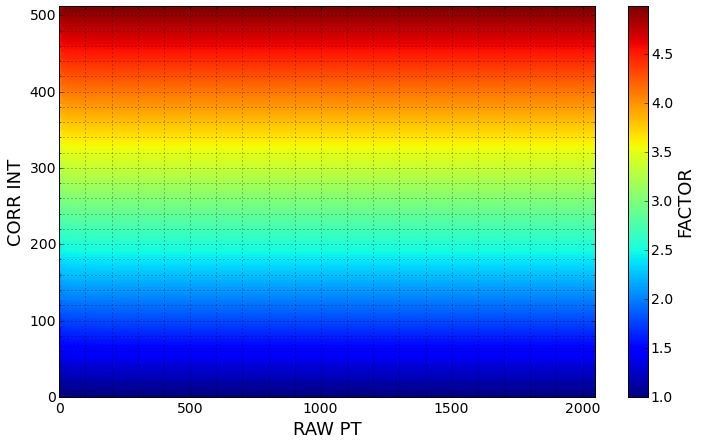

In [33]:
plt.pcolormesh(x, y, 1. * pt_corr_m / pt_raw_m)
plt.colorbar(label='FACTOR')
plt.xlim(0, len(pt_raw))
plt.ylim(0, len(pt_corr_m[:,0]))
plt.xlabel("RAW PT")
plt.ylabel("CORR INT")
plt.minorticks_on()
plt.grid(which='both')

# Deriving correction LUTs 

We need 2 LUTs:

1) to map (pT, eta) -> address. This compresses the pT from 11 bits down to 8 bits (or however many).

2) to map index -> correction factor (int). The correction factor will be an integer in the range 0 - 2^N -1

(1) is easy to make, we did it above (see `new_pt_mapping` dict)

(2) is harder, because we need to find an integer correction factor such that we end up with the correct corrected value.

There are 2 ways to solve this:

a) try and figure out the integer factor required, alhtough difficult as left shifting loses info

b) look it up in a map

## Mapping

For the mapping option, we have 2 possibilities as to how to retrieve the factor:

- create a matrix where indices along the 2 axies are PRE and POST HW pT, and the entries are the integer factor. Since we cannot acheive every POST pT, for those values use factor that gives the closest POST

- create a matrix where the indices are PRE and FACTOR, and entries are POST. This is a bit slower in lookup, as we have to figure out the closest value each time, but is easier to create.

###  PRE & POST

###  PRE & FACTOR

In [34]:
def get_factor(pt_pre, pt_post):
    """Return multiplicative factor that gives closest 
    value to pt_post for a given pt_pre.
    
    pt_pre and pt_post are HW values
    """
    pt_pre = int(round(pt_pre))
    pt_post = int(round(pt_post))
    try:
        ind = int(np.where(pt_corr_m[:, pt_pre-1] == pt_post)[0][0])
        return ind
    except IndexError:
        ind = bisect_left(pt_corr_m[:, pt_pre-1], pt_post)
        if ind == len(pt_corr_m[:, pt_pre-1]):
            ind -= 1
            return ind
        if abs(pt_corr_m[ind, pt_pre-1] - pt_post) < (abs(pt_corr_m[ind-1, pt_pre-1] - pt_post)):
            return ind
        else:
            return ind-1


print get_factor(252,261)
pt_corr_m[4, 251]

5


259

In [35]:
pt_corr_m[:, 7-1]

array([ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19,
       19, 19, 19, 19, 19

In [36]:
target = 2**8
merge = 1.01
# these hold physical values
new_pt_mapping, new_corr_mapping = calc_new_mapping(target, merge)

# hold HW pt : integer factor
lut_mapping = OrderedDict()

for pt in sorted(set(new_pt_mapping.values())):
    pt_pre = int(round(pt * 2))
    pt_post = int(round(pt * new_corr_mapping[pt] * 2))
    lut_mapping[pt_pre] = get_factor(pt_pre, pt_post)

Quantised above (inclusive): 119.0


In [37]:
pt_n = np.array(lut_mapping.keys()) * 0.5
pt_corr_real = np.array([p*0.5 * new_corr_mapping[p*0.5] for p in lut_mapping.keys()])
pt_corr_lut = np.array([(((p * f)>>7) + p)*0.5 for p, f in lut_mapping.iteritems()])

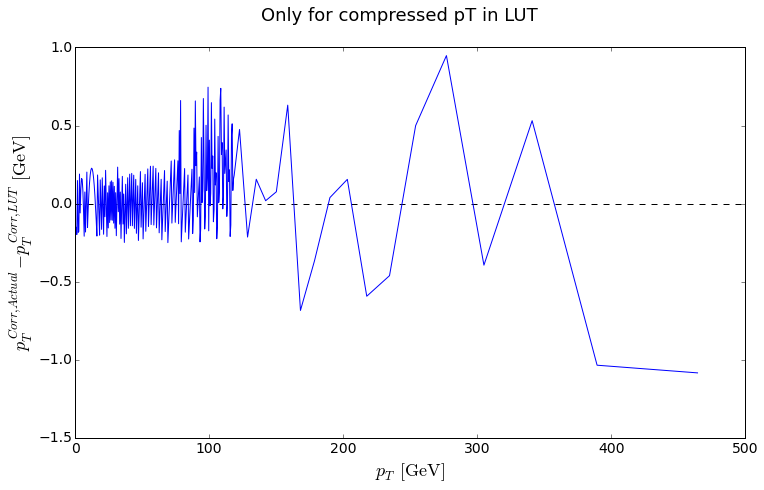

In [38]:
plt.plot(pt_n, pt_corr_real - pt_corr_lut)
plt.hlines(0, plt.xlim()[0], plt.xlim()[1], linestyle='dashed')
plt.xlabel(r'$p_T\ \mathrm{[GeV]}$')
plt.ylabel(r'$p_T^{Corr,Actual} - p_T^{Corr,LUT}\ \mathrm{[GeV]}$')
plt.suptitle('Only for compressed pT in LUT')

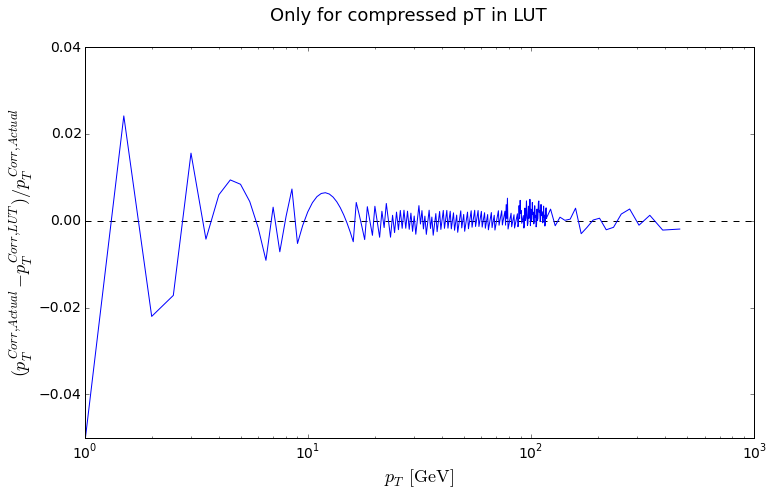

In [39]:
plt.plot(pt_n, (pt_corr_real - pt_corr_lut)/pt_corr_real)
plt.xscale('log')
plt.xlim(1, 1000)
plt.ylim(-0.05, 0.04)
plt.hlines(0, plt.xlim()[0], plt.xlim()[1], linestyle='dashed')
plt.xlabel(r'$p_T\ \mathrm{[GeV]}$')
plt.ylabel(r'$(p_T^{Corr,Actual} - p_T^{Corr,LUT})/p_T^{Corr,Actual}}$')
plt.suptitle('Only for compressed pT in LUT')

In [40]:
print 'physical pt, corrected pt (function), corrected pt (lut map), diff'
for pt, f_int in lut_mapping.iteritems():
    lut_corr = (((pt * f_int)>>7) + pt) * 0.5
    real_corr = pt * 0.5 * new_corr_mapping[pt*0.5]
    print pt * 0.5, real_corr, lut_corr, real_corr - lut_corr

physical pt, corrected pt (function), corrected pt (lut map), diff
0.5 1.34869914802 1.5 -0.151300851985
1.0 3.80300520326 4.0 -0.196994796738
1.5 6.1485071865 6.0 0.1485071865
2.0 8.3166566153 8.5 -0.183343384704
2.5 10.3223868039 10.5 -0.177613196117
3.0 12.1898728804 12.0 0.189872880437
3.5 13.9408823114 14.0 -0.0591176885669
4.0 15.5932602516 15.5 0.0932602516416
4.5 17.1613552165 17.0 0.161355216507
5.0 18.6567192989 18.5 0.156719298925
5.5 20.0887285749 20.0 0.0887285749196
6.0 21.4650707342 21.5 -0.03492926581
6.5 22.7921155196 23.0 -0.207884480362
7.0 24.0751942217 24.0 0.0751942217074
7.5 25.3188113386 25.5 -0.181188661376
8.0 26.5268061653 26.5 0.026806165291
8.5 27.7024773702 27.5 0.202477370208
9.0 28.8486800319 29.0 -0.151319968075
9.5 29.9679019991 30.0 -0.0320980008887
10.0 31.0623245744 31.0 0.0623245743639
10.5 32.1338711931 32.0 0.133871193059
11.0 33.1842468178 33.0 0.184246817811
11.5 34.214970084 34.0 0.214970084047
12.0 35.2273997345 35.0 0.22739973447
12.5 36.222

## Putting it together

Now we compare all PT values, not just the compressed ones. We will compare the "actual" corrected values to the ones derived using the LUT

In [41]:
pt_orig, corr_orig

lut_corr_compressed = OrderedDict()

for pt in pt_orig:
    comp_pt = new_pt_mapping[pt]
    hw_pt = int(round(pt * 2))
    hw_comp_pt = int(round(comp_pt * 2))
    f = lut_mapping[hw_comp_pt]
    new_pt = ((f * hw_pt)>>7) + hw_pt
    lut_corr_compressed[pt] = new_pt * 0.5

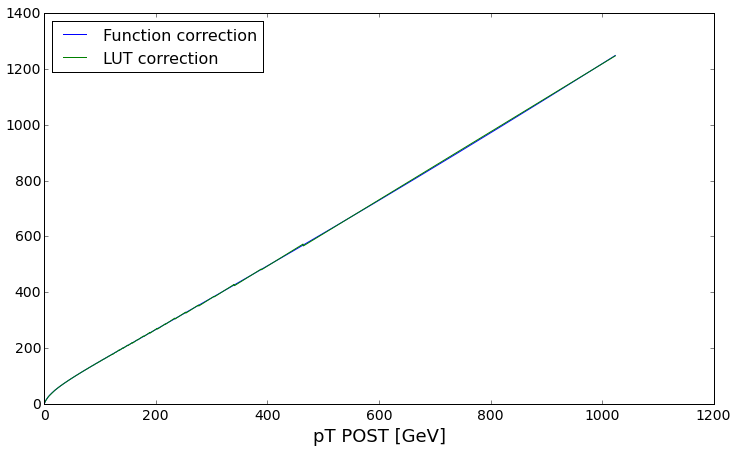

In [42]:
plt.plot(pt_orig, pt_orig * corr_orig, label='Function correction')
plt.plot(lut_corr_compressed.keys(), lut_corr_compressed.values(), label='LUT correction')
plt.xlabel('pT PRE [GeV]')
plt.xlabel('pT POST [GeV]')
plt.legend(loc=0)
# plt.xlim(100, 180)
# plt.ylim(140, 220)

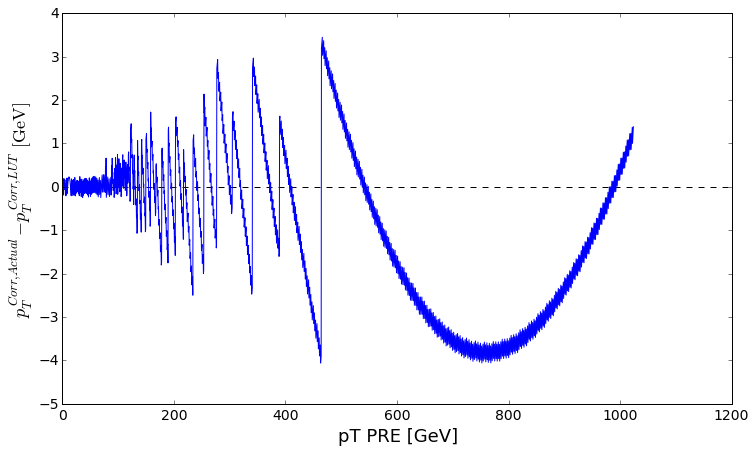

In [43]:
corrected_pt = pt_orig * corr_orig
plt.plot(pt_orig, corrected_pt - lut_corr_compressed.values())
plt.xlabel('pT PRE [GeV]')
plt.ylabel(r'$p_T^{Corr,Actual} - p_T^{Corr,LUT}\ \mathrm{[GeV]}$')
plt.hlines(0, plt.xlim()[0], plt.xlim()[1], linestyle='dashed')

# plt.xlim(right=150)

(0, 100)

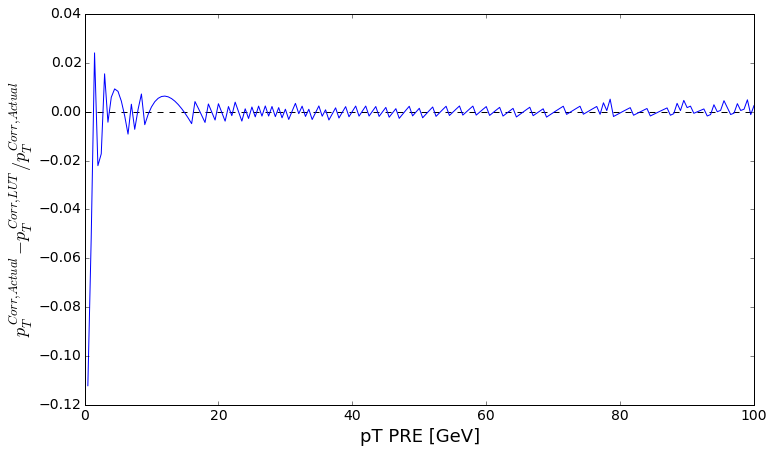

In [44]:
plt.plot(pt_orig, (corrected_pt - lut_corr_compressed.values())/(pt_orig * corr_orig))
plt.xlabel('pT PRE [GeV]')
plt.ylabel(r'$p_T^{Corr,Actual} - p_T^{Corr,LUT}/p_T^{Corr,Actual}$')
plt.hlines(0, plt.xlim()[0], plt.xlim()[1], linestyle='dashed')
# plt.xscale('log')
plt.xlim(0, 100)
# plt.ylim(-0.05, 0.04)

So we can see that it performs pretty well! The maximum absolute difference is 4 GeV at very high pT, which we don't care about anyway. At smaller pT, there is a maximum 5% deviation, for pT = 1. Above that, the worst deviation is about 2%.


Where the compressed pT bins start at ~ 120 GeV the difference is more noticeable - the maximum is about 1 GeV, ie ~ 1%.

### Rounding the 'actual' corrected pT

In reality, the L1 output is quantised to 0.5 GeV, so the comparison isn't exactly as above.

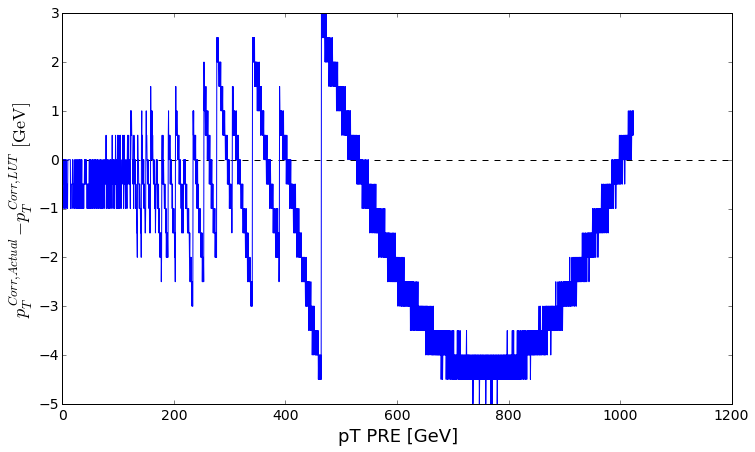

In [45]:
corrected_pt = pt_orig * corr_orig
plt.plot(pt_orig, corrected_pt.astype(int) - lut_corr_compressed.values())
plt.xlabel('pT PRE [GeV]')
plt.ylabel(r'$p_T^{Corr,Actual} - p_T^{Corr,LUT}\ \mathrm{[GeV]}$')
plt.hlines(0, plt.xlim()[0], plt.xlim()[1], linestyle='dashed')

# plt.xlim(right=150)

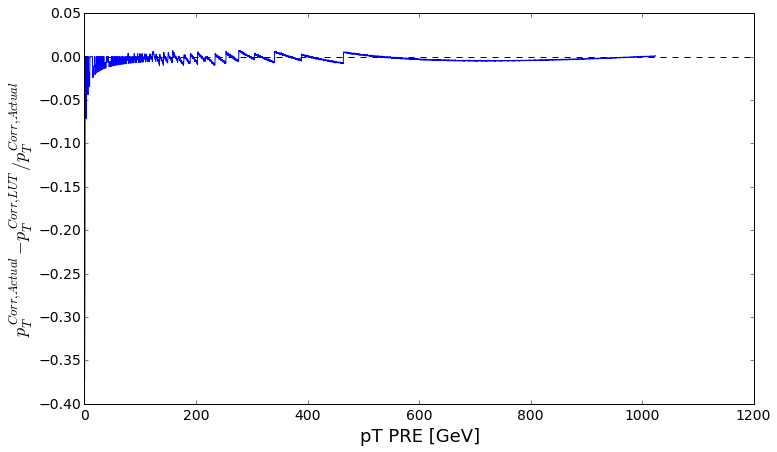

In [46]:
plt.plot(pt_orig, (corrected_pt.astype(int) - lut_corr_compressed.values())/(pt_orig * corr_orig))
plt.xlabel('pT PRE [GeV]')
plt.ylabel(r'$p_T^{Corr,Actual} - p_T^{Corr,LUT}/p_T^{Corr,Actual}$')
plt.hlines(0, plt.xlim()[0], plt.xlim()[1], linestyle='dashed')
# plt.xscale('log')
# plt.xlim(0, 100)
# plt.ylim(-0.05, 0.04)

It appears that the LUT correction slightly under-calibrates (this depends on exactly how the pT is rounded - I suspect I have done it wrong)